# Final Project: Adaptive VWAP in Trade Execution

## By Group 1
- Wenting Ge (wg2305)
- Xiaojin Jin (xj2210)
- Yuanyi Liang (yl3674)
- Jiaying Lu (jl4958)
- You Wu (yw3027)
- Yilun Yao (yy2787)

In [222]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from sklearn import linear_model as linear_model
from sklearn.linear_model import LogisticRegression
import time
import datetime
import sys
from scipy import optimize
import scipy.stats as st
import math

import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
import plotly.tools as tls
tls.embed('https://plot.ly/~cufflinks/8')
# please modify according to your plotly account
tls.set_credentials_file(username='wuyouk', api_key='rXE0eoflxZKbSC0Q9tWz')

matplotlib.rcParams[ 'figure.figsize' ] = ( 15, 6 )

In [223]:
# Utility functions
def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

## Read and process data

### Min bar data

In [3]:
# Processing and generate Min bar Data
path = 'Data/'
ticker = 'AAPL'
# Read bar data file
file = 'bar_' + ticker + '_170101_180413.csv'
raw_bar_data = pd.read_csv( path + file, parse_dates=[['<DATE>', '<TIME>']] )
raw_bar_data.drop('<PER>', axis=1, inplace=True)
raw_bar_data['<DATE>_<TIME>'] =  pd.to_datetime(raw_bar_data['<DATE>_<TIME>'], format='%Y-%m-%d %H:%M:%S.%f')
raw_bar_data.rename(columns={'<DATE>_<TIME>': 'Time', '<TICKER>': 'Symbol', \
                     '<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', \
                     '<CLOSE>': 'Trade Price', '<VOL>': 'Trade Volume'}, inplace=True)
raw_bar_data['Symbol'] = ticker
raw_bar_data.set_index('Time', inplace=True)
raw_bar_data = raw_bar_data['2018-03-01':'2018-04-13']
raw_bar_data.head()

,Symbol,Open,High,Low,Trade Price,Trade Volume
Time,,,,,,
2018-03-01 09:31:00,AAPL,178.50,178.73,178.36,178.58,9689
2018-03-01 09:32:00,AAPL,178.57,179.31,178.57,179.23,17865
2018-03-01 09:33:00,AAPL,179.21,179.35,179.08,179.20,13842
2018-03-01 09:34:00,AAPL,179.29,179.31,178.90,178.90,13869
2018-03-01 09:35:00,AAPL,178.97,179.12,178.84,178.90,11234


In [4]:
my_raw_bar_data = raw_bar_data.copy()

### Tick data

In [5]:
# Processing and generate Tick Data
path = 'Data/'
ticker = 'AAPL'
# Read tick data file
file = 'tick_' + ticker + '_20180117.gz'
raw_tick_data = pd.read_csv( path + file, parse_dates = True )
raw_tick_data['Time'] =  pd.to_datetime(raw_tick_data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
raw_tick_data.set_index('Time', inplace=True)
raw_tick_data.head()

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sale Condition,Trade Volume,Trade Price
Time,,,,,,,,,,
2018-01-17 04:00:00.015039233,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@ TI,25.0,174.21
2018-01-17 04:00:00.015042660,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@ TI,1.0,174.21
2018-01-17 04:00:00.015050355,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@ TI,1.0,174.21
2018-01-17 04:00:00.015062641,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@ TI,73.0,174.21
2018-01-17 04:00:00.015072361,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@ T,127.0,174.21


In [6]:
my_raw_tick_data = raw_tick_data.copy()

## Get static target curve

In [7]:
# Preprocess data to generate static curve
def static_preprocess(my_raw_bar_data):
    # add a minute bin
    # US start of date, calc in minutes
    start_of_day = (9 * 60) + 30
    # get the time for each bin in minutes and subtract 9:30
    my_raw_bar_data[ 'Minute_bars' ] = (my_raw_bar_data.index.hour * 60) + my_raw_bar_data.index.minute - start_of_day

    # remove anything beyond bin 389
    my_raw_bar_data = my_raw_bar_data[ my_raw_bar_data.Minute_bars <= 390 ]

    # calculate the cumulative pct by day
    # totl_volume = raw_bar_data.groupby( [ bar_data.index.date ] ).tail( 1 )[ 'Trade Volume' ] 
    my_raw_bar_data[ 'Accum Volume' ] = my_raw_bar_data.groupby( [ my_raw_bar_data.index.date ] ).cumsum()[ 'Trade Volume' ] 
    my_raw_bar_data[ 'Accum Pct' ] = my_raw_bar_data.groupby( [ my_raw_bar_data.index.date ] )[ 'Accum Volume' ].transform( lambda x: x / x.iloc[ -1 ] )

    # select the time period in which we would like to train the target curve, and calibrate delta later
#     bar_data = my_raw_bar_data[ '01-21-2017':'12-31-2017' ].copy()
#     bar_data.tail()
    return my_raw_bar_data

### Method 1: by regression 

In [8]:
# Use regression method to generate static curve
def get_static_reg(bar_data):
    # arrange our data
    minute_bars = bar_data[ 'Minute_bars' ]
    X = pd.DataFrame( { 'bin': minute_bars, 
                        'bin2' : minute_bars**2, 
                        'bin3' : minute_bars**3, 
                        'bin4' : minute_bars**4, 
                        'bin5' : minute_bars**5 } )
    y = bar_data[ 'Accum Pct' ]
    
    # now do the regression with no intercept
    lm = linear_model.LinearRegression( fit_intercept = False )
    model = lm.fit( X, y )
    predictions = lm.predict( X )
    # Rsquared
    lm.score( X, y )
    
    # coefficients
    coefs = lm.coef_
    
    # use coefs to generate the target curve
    def vwap_target_regr( bar_num, coefs ):
        return ( coefs[ 0 ] * bar_num + 
                 coefs[ 1 ] * bar_num**2 + 
                 coefs[ 2 ] * bar_num**3 +
                 coefs[ 3 ] * bar_num**4 +
                 coefs[ 4 ] * bar_num**5 )

    static_target_regr = vwap_target_regr( bar_data[ 'Minute_bars' ].unique(), coefs )
    static_target_regr[-1] = 1
    return static_target_regr

### Method 2: by binwise median

In [9]:
# Use regression method to generate static curve
def get_static_med(bar_data):
    bar_data['Pct'] = bar_data.groupby([bar_data.index.date])['Trade Volume'].transform( lambda x: x / x.sum() )
    min_bar_median = bar_data.groupby([bar_data.index.hour,bar_data.index.minute])['Pct'].median()
    
    # set index for the dataframe
    index = [datetime.time(ind[0],ind[1]) for ind in min_bar_median.index]
    min_bar_median = pd.DataFrame(min_bar_median)
    min_bar_median.index = [datetime.time(ind[0],ind[1]) for ind in min_bar_median.index]
    
    #pre trading curve
    min_bar_median['pre_trading_curve'] = min_bar_median['Pct'].transform(lambda x: x/x.sum() )
    min_bar_median['cum_trading_curve'] = min_bar_median['pre_trading_curve'].cumsum()
    
    # Static Trading Curve
    static_target_med = min_bar_median['cum_trading_curve'].reset_index(drop=True)
    return static_target_med

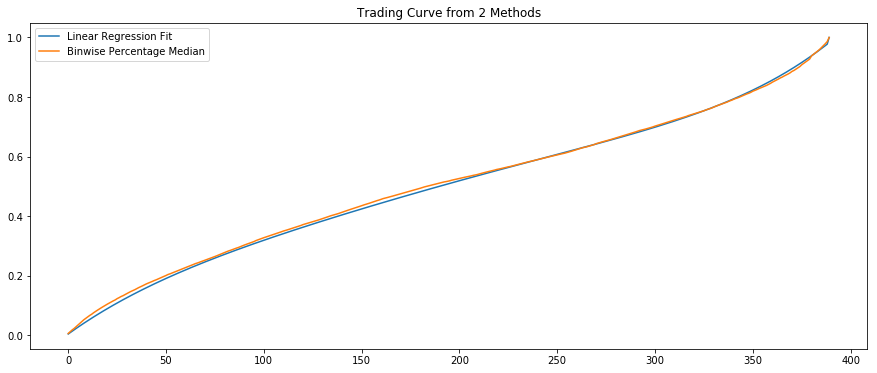

In [10]:
# Generate static trading curves and plot
my_raw_bar_data = raw_bar_data.copy()
bar_data = static_preprocess(my_raw_bar_data)
static_target_regr = get_static_reg(bar_data)
static_target_med = get_static_med(bar_data)

regr_plot = plt.plot( static_target_regr, label = 'Linear Regression Fit' )
med_plot = plt.plot( static_target_med, label = 'Binwise Percentage Median' )
plt.title( 'Trading Curve from 2 Methods' )
plt.legend()

## Filter tick data

### Apply a filter to remove market data with abnormal price change

In [11]:
# Filter tick data to remove quote price that changes more than 1 percent, trade price that changes more than 0.5 percent
# Bar data are assumed to be correct and do not require filtering
def filter_data(trading_day):
    show_time('Filter start')

    bid_price = trading_day.loc[0, 'Bid_Price']
    offer_price = trading_day.loc[0, 'Offer_Price']
    last_price = trading_day.loc[0, 'Trade Price']

    i = trading_day.index[0] - 1
    for index, row in trading_day.iterrows():
        i += 1
        if pd.isnull( row[ 'Trade Price' ] ):  # it's a quote
            # check if quote is a one-sided quote
            if ('Y' in row['Quote_Condition']):
                trading_day = trading_day.drop( i )
                continue

                if (row['Bid_Price'] > 0) and (abs( row[ 'Bid_Price' ] - bid_price ) / bid_price > 0.01):
                    trading_day = trading_day.drop( i )
                    continue
                if (row['Offer_Price'] > 0) and (abs( row[ 'Offer_Price' ] - offer_price ) / offer_price > 0.01):
                    trading_day = trading_day.drop( i )
                    continue
                # since it is a one-sided quote, we only update the bid_price or offer_price if it is not zero
                if (row['Bid_Price'] > 0):
                    bid_price = row[ 'Bid_Price' ]
                else:
                    offer_price = row[ 'Offer_Price' ]
                continue      

            if ( bid_price != 0 ) and abs( row[ 'Bid_Price' ] - bid_price ) / bid_price > 0.01:
                trading_day = trading_day.drop( i )
                continue

            if ( offer_price != 0 ) and abs( row[ 'Offer_Price' ] - offer_price ) / offer_price > 0.01:
                trading_day = trading_day.drop( i )
                continue

            # collect BBO
            bid_price = row[ 'Bid_Price' ]
            offer_price = row[ 'Offer_Price' ]

        else:  # it's a trade
            if ( last_price != 0 ) and abs( row[ 'Trade Price' ] - last_price ) / last_price > 0.005:
                trading_day = trading_day.drop( i )
                continue

            # record last trade price and volume
            last_price = row[ 'Trade Price' ]

    show_time('Filter end')
    return trading_day

In [12]:
# Generate filtered tick data as my_filtered_tick_data
my_raw_tick_data = raw_tick_data.copy()
my_raw_tick_data = my_raw_tick_data[ '2018-01-17 09:30:00':'2018-01-17 16:00:00'].copy()
my_raw_tick_data.reset_index(inplace = True)
my_filtered_tick_data = filter_data(my_raw_tick_data)
my_filtered_tick_data.head()

Filter start : 2018-04-18 23:33:02:017322
Filter end : 2018-04-18 23:37:56:388702


,Time,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sale Condition,Trade Volume,Trade Price
0,2018-01-17 09:30:00.013454825,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@F I,44.0,176.15
1,2018-01-17 09:30:00.029276218,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@,100.0,176.15
2,2018-01-17 09:30:00.029355650,Z,AAPL,176.12,1.0,176.54,3.0,R,NaN,NaN,NaN
3,2018-01-17 09:30:00.029361349,Z,AAPL,175.71,3.0,176.54,3.0,R,NaN,NaN,NaN
4,2018-01-17 09:30:00.037869801,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,@ I,70.0,176.10


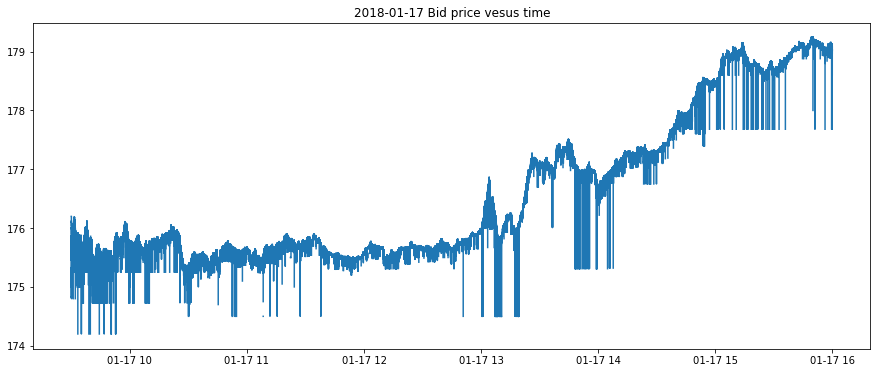

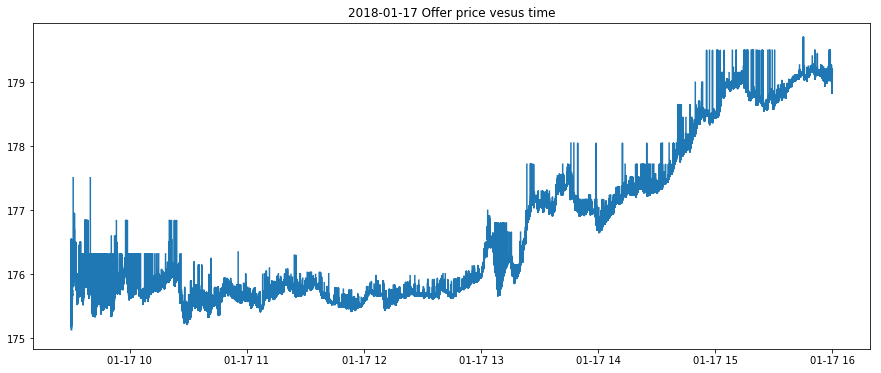

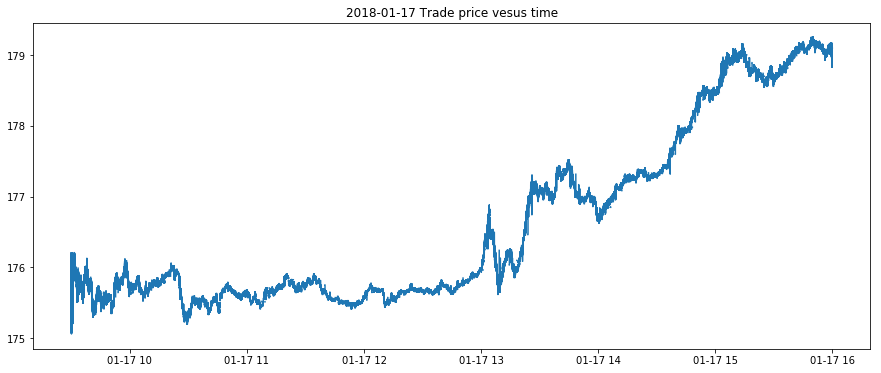

In [13]:
# Plot bid price, ask price and trade price against time
tick_data = my_filtered_tick_data.copy()
tick_data.set_index('Time', inplace=True)
bid_price = tick_data[:]['Bid_Price']
offer_price = tick_data[:]['Offer_Price']
trade_price = tick_data[:]['Trade Price']

# now plot the price again
plt.plot(bid_price)
plt.title( '2018-01-17 Bid price vesus time' )
plt.show()

plt.plot(offer_price)
plt.title( '2018-01-17 Offer price vesus time' )
plt.show()

plt.plot(trade_price)
plt.title( '2018-01-17 Trade price vesus time' )
plt.show()

## Get trading signals

### Signal - VCV Measure

In [16]:
# Backtesting for signal vcv to obtain a regression model for prediction
train_data = raw_bar_data.copy()
train_data['Time'] = train_data.index
train_data['Date'] = pd.to_datetime(train_data['Time'].dt.date)

# 1) Use 20% of the training data to calc sample mean and sample std deviation
percent = 0.2
daily_min = 390

# Number of rows/timestamps in the training data
n_rows = len(train_data.index)
sample_rows = int (np.ceil((n_rows/daily_min * percent))) * daily_min
cut_date = train_data.iloc[sample_rows]['Date']
sample_data = train_data[(train_data['Date'] <= cut_date)]

# Transaction Amt = numbers of shares traded * close price
# Calculate the transaction amount of each minute, sample mean, sample stdev, and vcv
sample_transact_amt =  sample_data[ 'Trade Volume' ] * sample_data[ 'Trade Price' ]
sample_transact_mean = np.mean(sample_transact_amt)
sample_transact_stdev = sample_transact_amt.std()
vcv_benchmark = sample_transact_stdev / sample_transact_mean

# 2) Calculate vcv of each min for each day
# calc daily_vwap for each day

roll_data = train_data[(train_data['Date'] > cut_date)].copy()

# add prev date to the roll data df
roll_data['prev date'] = roll_data.Date.shift(1)
roll_data.loc[roll_data['Time'] == roll_data.iloc[0]['Time'], 'prev date'] = roll_data.iloc[0]['Date']

roll_date_data = roll_data.set_index(['Date'])
min_transact_amt = roll_date_data['Trade Volume'] * roll_date_data['Trade Price']
min_quantity = roll_date_data['Trade Volume']
daily_transact_amt= min_transact_amt.groupby(level=0).sum().reset_index(name = 'daily_transact_amt')
daily_quantity= min_quantity.groupby(level=0).sum().reset_index(name = 'daily_quantity')

transact_vol = pd.merge(daily_transact_amt, daily_quantity, how='left', on=['Date'])

transact_vol['daily_vwap'] = transact_vol['daily_transact_amt'] / transact_vol['daily_quantity']
roll_data = roll_data.set_index(['Time'])

# initialize
cur_transact_mean = sample_transact_mean
cur_transact_stdev = sample_transact_stdev
rows_count = len(sample_data)
total_transact_amt = 0
total_quantity = 0
count = 0

#set a rate applied on daily_vwap
rate = 0.000001

cur_vcv_array = np.array([])
price_diff_array = np.array([])
label_array = np.array([])

for index,row in roll_data.iterrows():
    cur_date = row['Date']
    past_date = row['prev date']
    
    if str(past_date) == str(cur_date):
        close_price = row[ 'Trade Price' ]
        cur_quantity = row[ 'Trade Volume' ]
        cur_transact_amt = close_price * cur_quantity
        prev_transact_mean = cur_transact_mean
        cur_transact_mean = (prev_transact_mean * rows_count + cur_transact_amt) / (rows_count + 1) 
        cur_transact_stdev = np.sqrt((((rows_count + 1) - 2) * cur_transact_stdev**2 + (cur_transact_amt - cur_transact_mean) * (cur_transact_amt - prev_transact_mean)) / ((rows_count + 1) - 1))
        # Update current vcv
        cur_vcv = cur_transact_stdev /  cur_transact_mean 
        # Calc running vwap
        total_transact_amt += cur_transact_amt
        total_quantity += cur_quantity
        avg_vwap = total_transact_amt / total_quantity
        
        rows_count += 1
        count += 1
        
        price_diff = close_price - avg_vwap
        cur_vcv_array = np.append(cur_vcv_array,[cur_vcv])
        price_diff_array = np.append(price_diff_array,[price_diff])

    else:
        cur_transact_mean = sample_transact_mean
        cur_transact_stdev = sample_transact_stdev
        total_transact_amt = 0
        total_quantity = 0
        rows_count = len(sample_data)

        close_price = row[ 'Trade Price' ]
        cur_quantity = row[ 'Trade Volume' ]
        cur_transact_amt = close_price * cur_quantity
        prev_transact_mean = cur_transact_mean
        cur_transact_mean = (prev_transact_mean * rows_count + cur_transact_amt) / (rows_count + 1) 
        cur_transact_stdev = np.sqrt((((rows_count + 1) - 2) * cur_transact_stdev**2 + (cur_transact_amt - cur_transact_mean) * (cur_transact_amt - prev_transact_mean)) / ((rows_count + 1) - 1))
        # Update current vcv
        cur_vcv = cur_transact_stdev /  cur_transact_mean 
        # Calc running vwap
        total_transact_amt += cur_transact_amt
        total_quantity += cur_quantity
        avg_vwap = total_transact_amt / total_quantity
        
        rows_count += 1
        count += 1
        
        price_diff = close_price - avg_vwap
        cur_vcv_array = np.append(cur_vcv_array,[cur_vcv])
        price_diff_array = np.append(price_diff_array,[price_diff])
    # Convert vcv to signal
    # Assume we are on the order side of buy
    # if the current close price (of the min) > cur_vwap (of the day)* (1+ rate), return -1
    # if the current close price (of the min) < cur_vwap (of the day)* (1+ rate), return 1
    # else, return 0
    cur_vwap = transact_vol.loc[transact_vol['Date'] == cur_date, 'daily_vwap'].iloc[0]
    cur_vwap_up = cur_vwap * (1 + rate)
    cur_vwap_down = cur_vwap * (1 - rate)
    
    if close_price > cur_vwap_up:
        label = -1
    elif close_price < cur_vwap_down:
        label =  1
    else:
        label = 0
    
    label_array = np.append(label_array,[label])

train_vec_array = [list(t) for t in zip(cur_vcv_array, price_diff_array)]
label_array = label_array.astype(int)

# apply multi-class logistic regression
model=LogisticRegression(C=1e30,multi_class="multinomial",solver="sag")
X = train_vec_array
Y = label_array
model.fit(X,Y)

/Users/Johnson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
# Signal: vcvmeasure
steph_raw_bar_data = raw_bar_data.copy()
# steph_raw_bar_data['Date'] = steph_raw_bar_data.index.date

# Initialization for signal vcv measure
def initialize_vcvmeasure(raw_bar_data = steph_raw_bar_data):
    # Trading volumn = numbers of shares traded * close price
    # Calculate the trading volumn of each miniute
    prev_vol =  raw_bar_data[ 'Trade Volume' ] * raw_bar_data[ 'Trade Price' ] 

    # Derive the sample mean and standard deviation for the transaction amount per minute
    prev_vol_mean = np.mean(prev_vol)
    prev_vol_stdev = np.std(prev_vol)

    # Calculate the vcv = sample std dev/ sample mean
    vcv_benchmark = prev_vol_stdev / prev_vol_mean

    # Number of rows/timestamps in the training data
    prev_rows = len(raw_bar_data.index)

    # initialization of parameter set used for vcv signal 

    cur_vol_mean = prev_vol_mean
    cur_vol_stdev = prev_vol_stdev
    n_rows = prev_rows
    total_vol = 0
    total_transact_amt = 0
    parameters = cur_vol_mean, cur_vol_stdev, n_rows, total_vol, total_transact_amt, vcv_benchmark
    return parameters

# get signal from vcv measure
def get_signal_vcvmeasure(trade_bk, quote_bk, parameters):
    
    cur_vol_mean, cur_vol_stdev, n_rows, total_vol, total_transact_amt, vcv_benchmark = parameters 
    
    #calc cur_vol using trade_bk dataframe
    cur_transact_amt = (trade_bk[ 'Trade Price' ] * trade_bk[ 'Trade Volume' ]).sum()
    total_transact_amt += cur_transact_amt
    
    #calc cur_avg_price
    cur_avg_price = cur_transact_amt / (trade_bk[ 'Trade Volume' ]).sum()
    
    #calc cur_vwap_price
    #calc running total_vol
    total_vol += trade_bk[ 'Trade Volume' ].sum()
    running_vwap = total_transact_amt / total_vol
    
    # Calculate running mean and running standard deviation
    past_vol_mean = cur_vol_mean
    # Running mean of transaction amount per minute
    cur_vol_mean = (past_vol_mean * n_rows + cur_transact_amt) / (n_rows + 1) 
    cur_vol_stdev = np.sqrt((((n_rows + 1) - 2) * cur_vol_stdev**2 + (cur_transact_amt - cur_vol_mean) * (cur_transact_amt - past_vol_mean)) / ((n_rows + 1) - 1))
    
    # Update current vcv
    cur_vcv = cur_vol_stdev / cur_vol_mean 
    
    # Calc running nrows
    n_rows = n_rows + 1
    
    #update the parameters
    parameters = cur_vol_mean, cur_vol_stdev, n_rows, total_vol, total_transact_amt, vcv_benchmark
    
    #print(cur_vcv)
    
    # Compare the current vcv (vcv a) against the vcv calculated from the training data (vcv b)
    # Based on the paper, price changes due to informed trading are likely to be predictive of future price changes, 
    # thereby pushing up return autocorrelations
    # 1) If vcv_a > vcv_b, the proportion of informed trades goes up, which indicates that we can predict the future price changes 
    # we then compare the current price(i.e. close_price) and the benchmark price (i.e. vwap_price)
    # When close_price > vwap_price, we predict that in the future, the stock price is very likely to increase
    # therefore, a buyer will trade right now (return 1) and a seller will not trade (return -1). 
    # When close_price <= vwap_price, a buyer will not trade (return -1) and a seller will trade (return 1)
    # 2) If vcv_a <= vcv_b, the proportion of informed trades goes down, which indicates that it's unlikely for us to 
    # predict the future price changes. Therefore, both buyer and seller will do nothing (return 0)
    #print(cur_vcv,vcv_benchmark)
    
    # here, assume that the order side is buy
    if cur_vcv > vcv_benchmark:
        if cur_avg_price > running_vwap:
            return (1, parameters)
        else:
            return (-1, parameters)
    else:
        return 0, parameters
    
    

### Signal - Level-one quote with hidden liquidity

In [110]:
# Signal: level-one quote with hidden liquidity

# Below probability are obtained from backtesting on five days Apple tick data
# Backtesting code is included in a separate notebook named: 

# Below probability are obtained from backtesting on five days Apple tick data
# Backtesting code is included in a separate notebook named: 
model_prob = \
np.array([[ 0.5       ,  0.46968052,  0.4428279 ,  0.41887966,  0.39738879],
       [ 0.53031948,  0.5       ,  0.47295989,  0.4486944 ,  0.4267973 ],
       [ 0.5571721 ,  0.52704011,  0.5       ,  0.4755991 ,  0.453469  ],
       [ 0.58112034,  0.5513056 ,  0.5244009 ,  0.5       ,  0.47776893],
       [ 0.60261121,  0.5732027 ,  0.546531  ,  0.52223107,  0.5       ]])

seperator_b = np.array([   1.,  130.,  190.,  300.,  530.])

seperator_a = np.array([   1.,   60.,   85.,  100.,  120.])

def get_signal_hl(trade_bk, quote_bk, sp):
    # n denotes the number of bucket
    n = 5
    res = 0
    if len(quote_bk) <= 0:
        return res, sp
    bidsize = quote_bk.iloc[-1]['Bid_Size']
    asksize = quote_bk.iloc[-1]['Offer_Size']
    #locate the busket of the bid sizes and ask sizes
    for i in range(n):
        if i == 0:
            if bidsize <= seperator_b[i+1]:
                bsize = (i+1)/n
            if asksize <= seperator_a[i+1]:
                asize = (i+1)/n
        elif i == n-1:
            if bidsize > seperator_b[i]:
                bsize = (i+1)/n
            if asksize > seperator_a[i]:
                asize = (i+1)/n
        else:
            if bidsize <= seperator_b[i+1] and bidsize > seperator_b[i]:
                bsize = (i+1)/n
            if asksize <= seperator_a[i+1] and asksize > seperator_a[i]:
                asize = (i+1)/n
    
    up_prob = model_prob[int(bsize*n - 1), int(asize*n-1)]
    if up_prob > 0.55:
        res = 1
    elif up_prob < 0.45:
        res = -1

    return res, sp
    

### Signal - VPIN Measure

In [206]:
# Signal : vpin

#AAPL 322 days average daily volume ON THIS EXCHANGE = 1719467
#We want the average signal time to be around 1 minutes, thus taking the whole trading period to be 390 minutes will give us 390 as the number of volume bars
#Therefore, dividing the average daily volume by 390 bars, we have each volume bar with size 4409

def vpin_train(bar_data):
    
    pList = []
    vList = []
    #Getting price changes, and volume bars.
    n = len(bar_data)
    
    for i in range(0, n):
        vList.append(float(bar_data.iloc[i]['Trade Volume']))
        #For the first row, use close price - open price to calculate price change.
        if i == 0:
            deltaP = float(bar_data.iloc[i]['Trade Price']) - float(bar_data.iloc[i]['Open'])
            pList.append(deltaP)
        #For the rest of the rows, use close price - previous close price.
        else:
            deltaP = float(bar_data.iloc[i]['Trade Price']) - float(bar_data.iloc[i-1]['Trade Price'])
            pList.append(deltaP)
    #Calculate standard deviation of deltaP.
    sd = np.std(pList)
    #Normalize the price changes.
    zList = [x/sd for x in pList] 
    #Use normal CDF to estimate percent of sell orders out of all orders.
    sellPercent = [st.norm.sf(x) for x in zList]
    
    #Setting volume block length.
    vBar = 4409
    
    #Initialize 
    volumeStart = 0
    VPINList = []
    deltaPList = []
    buyV = 0
    sellV = 0
    
    for i in range(0,n-1):
        #The case when current volume plus the volume of the next minute will not fill the current volume block.
        if volumeStart + vList[i]< vBar:
            if i == n - 2:
                break
            #Calculate accumulated total volume, buy volume and sell volume.
            else:
                volumeStart += vList[i]
                buyV += vList[i]*(1-sellPercent[i])
                sellV += vList[i]*(sellPercent[i])
        #The case when current volume plus the volume of the next minute will fill the current volume block.
        else:
            #Settle the current volume block.
            volumeFit = vBar - volumeStart
            buyV += volumeFit*(1-sellPercent[i])
            sellV += volumeFit*(sellPercent[i])
            bsDiff = (buyV-sellV)/vBar
            VPINList.append(bsDiff)
            deltaPList.append(pList[i+1] / float(bar_data.iloc[i]['Trade Price']))
            
            #Checking if the volume left can fill at least another block.
            fl = math.floor((vList[i] - volumeFit)/vBar)
            
            if fl >= 1:
                for j in range(fl):
                    bsDiff2 = vBar*(1-2*sellPercent[i])/vBar
                    VPINList.append(bsDiff2)
                    deltaPList.append(pList[i+1] / float(bar_data.iloc[i]['Trade Price']))
                    
            if i == n - 2:
                break        
            else:
                #Updating the starting volume for the next volume block.
                volumeStart = vList[i] - volumeFit - fl*vBar
                buyV = volumeStart*(1-sellPercent[i])
                sellV = volumeStart*(sellPercent[i])
                
    VPINarray = np.array(VPINList)
    cutoff = 0
    mrList = []
    boundList = []
    num_percentile = 20
    #Dividing the VPIN data into 20 percentiles.
    for i in range(num_percentile):
        #Get the boundary of each percentile.
        down = np.percentile(VPINarray,cutoff)
        up = np.percentile(VPINarray,cutoff+5)
        #Calculate the probability of observing mean reversion for the next minute.
        if i != num_percentile - 1:
            percentmr = sum(1 for j in range(0,len(VPINList)) if (VPINList[j]>=down and VPINList[j]<up and VPINList[j]*deltaPList[j] < 0))/sum(1 for j in range(0,len(VPINList)) if (VPINList[j]>=down and VPINList[j]<up))
        else:
            percentmr = sum(1 for j in range(0,len(VPINList)) if (VPINList[j]>=down and VPINList[j]<=up and VPINList[j]*deltaPList[j] < 0))/sum(1 for j in range(0,len(VPINList)) if (VPINList[j]>=down and VPINList[j]<=up))
        mrList.append(percentmr)
        boundList.append([down,up])
        cutoff += 5
        
    #Compute 95% confidence interval for the mean reversion probability.
    a = 1.0*np.array(mrList)
    aLen = len(a)
    m,se = np.mean(a), st.sem(a)
    CI = se*st.t._ppf((1+0.95)/2.,aLen-1)
    lower = m - CI
    upper = m + CI
    returnList = []
    #returnList.append(sd)
    #Return the boundary for calculating the signal.
    
    for num in range(0,len(mrList)):
        if mrList[num] <= lower and mrList[num] <0.5:
            returnList.append(boundList[num])
    
    return sd, returnList

In [150]:
vpin_bar_data = my_raw_bar_data.copy()

def initialize_vpin():

    previousP = 0
    volumeStart = 0
    buyV = 0
    sellV = 0
    sd, bound = vpin_train(vpin_bar_data)
    parameters = previousP, volumeStart, buyV, sellV, sd, bound
    
    return parameters

In [151]:
def get_signal_vpin(trade_bk, parameters):
    
    previousP, volumeStart, buyV, sellV, sd, bound = parameters
 
    if (previousP < 1e-4):
        #it is the first minute, so initialize previousP
        previousP = trade_bk.iloc[-1]['Trade Price']
        parameters = previousP, volumeStart, buyV, sellV, sd, bound
        return 0, parameters
    
    #Getting the incoming volume, current close price.
    currentV = float(sum(trade_bk['Trade Volume']))
    currentP = float(trade_bk.iloc[-1]['Trade Price']) 
    
    #Calculate current price change, standarize it, and compute the percentage of sell volumes.
    deltaP = currentP - previousP
    z = deltaP/sd 
    sellPercent = st.norm.sf(z)
    vBar = 4409
    signal = 0
    
    #Checking if the incoming volume will not fill the current volume block.
    if volumeStart + currentV< vBar:
        #Updating starting total/buy/sell volume for the next minute.
        volumeStart += currentV
        buyV += currentV*(1-sellPercent)
        sellV += currentV*(sellPercent)
        
    
    #Checking if the incoming volume will fill the current volume block.
    else:
        volumeFit = vBar - volumeStart
        buyV += volumeFit*(1-sellPercent)
        sellV += volumeFit*(sellPercent)
        bsDiff = (buyV-sellV)/vBar
        fl = math.floor((currentV - volumeFit)/vBar)
        
        #Checking if the volume left can fill at least another block.
        if fl >= 1:
            bsDiff = 1-2*sellPercent
        #Checking if the VPIN number is inside any of the boundaries.
        
        for num in bound:
            #Giving signal for buyer-leading VPIN.
            if bsDiff>=num[0] and bsDiff < num[1] and bsDiff > 0:
                signal = 1
            #Giving signal for seller-leading VPIN.
            elif bsDiff>=num[0] and bsDiff < num[1] and bsDiff < 0:
                signal = -1 
        #Updating the starting total/buy/sell volume.
        volumeStart = currentV - volumeFit - fl*vBar
        buyV = volumeStart*(1-sellPercent)
        sellV = volumeStart*(sellPercent)
    
    previousP = currentP
    parameters = previousP, volumeStart, buyV, sellV, sd, bound
    
    #print (signal)
        
    return signal, parameters

In [215]:
# Initialize signal parameters

def initialize_sp():    
    sp = [[]]*3
    sp[0] = initialize_vcvmeasure()
#     sp[2] = initialize_vpin()
    return sp

# Get trade signals from three methods
def get_signal( trade_bk, quote_bk, sp):
    s = np.zeros(3)
    s[0], sp[0] = get_signal_vcvmeasure(trade_bk, quote_bk, sp[0])
#     s[1], sp[1] = get_signal_hl(trade_bk, quote_bk, sp[1])
#     s[2], sp[2] = get_signal_vpin(trade_bk, sp[2])
    signal = sum(s)
    if signal > 1:
        signal = 1
    elif signal < -1:
        signal = -1
    return signal, sp

## Calibrate delta parameters for Adaptive target curve

In [21]:
# Calibrate delta parameter in generating adaptive trading curve
def calibrate_delta(bar_data, order_quantity, side, deltas):
    show_time('Calibrate start')
    n = len(deltas)
    dates = bar_data.index.date
    dates = sorted(list(set(dates)))
    m = len(dates)
    avg_price_each_delta = np.zeros(n)
    
    for i in range(n):
        delta = deltas[i]
        avg_price = np.zeros(m)
        for j in range(m):
            date = dates[j]
            date_to_select = str(date)
            one_day = bar_data[date_to_select]

            p_static = static_target_med
            p_adap = p_static.copy()

            current_bar = 0
            current_target = 0

            transaction_amt = 0
            shares = 0

            qty_filled = 0
            qty_remaining = order_quantity
            
            trade_bk = pd.DataFrame(columns=list(one_day))
            quote_bk = pd.DataFrame(columns=list(one_day))
            loc_bk = 0
            
            sp = initialize_sp()

            for index, row in one_day.iterrows():

                time_from_open = (index - pd.Timedelta( hours = 9, minutes = 30 ))
                minutes_from_open = (time_from_open.hour * 60) + time_from_open.minute
                current_bar = minutes_from_open - 1
                
                if pd.isnull( row[ 'Trade Price' ] ):  # it's a quote
                    pass
                else: # it's a trade
                    trade_bk = trade_bk.append(row, ignore_index = True)
                # get the new signal
                signal, sp = get_signal( trade_bk, quote_bk, sp)

                # based on the new signal, update the adaptive target curve
                p_adap = update_target_curve(p_adap, current_bar, signal, delta)
                current_target = np.ceil( min( p_adap[ current_bar - 1 ], 1 ) * order_quantity )

                qty_to_trade = current_target - qty_filled  
                close = row[ 'Trade Price' ]
                qty_filled += qty_to_trade
                qty_remaining -= qty_to_trade

                shares += qty_to_trade
                transaction_amt += qty_to_trade*close

                # "Clean up logic" that ensures the trade finishes if time is running out
                if (minutes_from_open==390) and (qty_remaining>0):
                    qty_to_trade = qty_remaining
                    qty_filled += qty_to_trade
                    qty_remaining -= qty_to_trade
                    shares += qty_to_trade
                    transaction_amt += qty_to_trade*close
            
#             show_time('Complete ' + str(date_to_select))
            avg_price[j] = transaction_amt/shares
            #print(i,j,avg_price[j])
        avg_price_each_delta[i] = np.average(avg_price)

        # print(delta, avg_price_each_delta[i])
    
    show_time('Calibrate end')
    if side == 'b':
        return deltas[np.argmin(avg_price_each_delta)]
    else:
        return deltas[np.argmax(avg_price_each_delta)]

In [22]:
# Use bar data to calibrate delta
bar_data = raw_bar_data.copy()
# set order parameters
order_quantity = 250000
# potential delta candidates in the update of the adaptive curve
deltas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
delta = calibrate_delta(bar_data, order_quantity, 's', deltas)
delta

Calibrate start : 2018-04-18 23:39:54:703873
Calibrate end : 2018-04-18 23:47:59:139819


0.9

## Adaptive trading curve

In [20]:
# Update adaptive trading curve according to the latest signal
def update_target_curve(p_adap, current_bar, signal, delta):
    N = 390
    p=[0]*390
    p[0] = p_adap[0]
    p[1:N] = np.diff(p_adap)
    n = current_bar
 
    if (n==N-1):
        p[N-1] = 1 - sum(p[0:N-1]) #0 to N-2
    else:     
        denom = np.sum(p[n+1:N])   
        if denom == 0:
            print('0 !!!!!!')
        for k in range(N-1, n-1, -1):
            if k >= n + 1:
                p[k] = p[k]*(1-delta*signal*p[n]/denom)
            elif k == n:
                p[k] = p[k]*(1+delta*signal)
            else:
                pass
        
    p_adap = np.cumsum(p)
    
    return p_adap

## Backtest on Min bar data

In [23]:
# record a trade
def record_trade(trades, idx, time, trade_px, trade_qty, current_bar ):
    trades.loc[ idx ] = [ time, trade_px, trade_qty, current_bar ]
    return trades

#round lot trading
def get_order_quantity( raw_order_qty, round_lot, qty_remaining ):
    if raw_order_qty >= round_lot: # round to nearest lot
        return np.around( int( raw_order_qty ), int( -1 * np.log10( round_lot ) ) )
    elif qty_remaining < round_lot:
        # we're less than 1 lot from completion, set for full size
        return qty_remaining 
    else:
        return -1

In [24]:
# Bar data trading
def trade_on_bar(trading_day, order_side, order_quantity, p_adap):
    trade_bk = pd.DataFrame(columns=list(trading_day))
    quote_bk = pd.DataFrame(columns=list(trading_day))
    loc_bk = 0
    
    sp = initialize_sp()
    
    total_volume, vwap_numerator, quantity_filled = 0, 0, 0
    
    trades = pd.DataFrame( columns = [ 'time', 'price' , 'shares', 'bar' ] )
    trade_index = 0

    for index, row in trading_day.iterrows():
        time_from_open = (row['Time'] - pd.Timedelta( hours = 9, minutes = 30 ))
        minutes_from_open = (time_from_open.hour * 60) + time_from_open.minute
        current_bar = minutes_from_open - 1

        if pd.isnull( row[ 'Trade Price' ] ):  # it's a quote
            pass
        else: # it's a trade
            trade_bk = trade_bk.append(row, ignore_index = True)
        
        signal, sp = get_signal( trade_bk, quote_bk, sp)

        if (order_side == 's'):
            signal = - signal
        
        # based on the new signal, update the adaptive target curve
        p_adap = update_target_curve(p_adap, current_bar, signal, delta)      
        current_target = min( np.ceil( p_adap[ current_bar ]*order_quantity ), order_quantity ) - quantity_filled
        
        last_price = row[ 'Trade Price' ]
        last_quantity = row[ 'Trade Volume' ]

        # collect volume
        total_volume += last_quantity

        # collect rolling VWAP
        vwap_numerator += last_quantity * last_price
        
        # record a trade
        trades = record_trade( trades, trade_index, row['Time'], last_price, current_target, current_bar)
        trade_index += 1
        quantity_filled += current_target
    
    vwap = vwap_numerator / total_volume
    avg_price = (trades[ 'price' ] * trades[ 'shares' ]).sum() / trades[ 'shares' ].sum()
    return trades, vwap, avg_price
        

In [25]:
def backtest(order_side, order_quantity, bar_data):
    
    dates = bar_data['Time'].dt.date
    dates = sorted(list(set(dates)))
    n_dates = len(dates)
    
    # set the static target and initialize the adaptive target
    p_static = static_target_med
    
    dates_trades = pd.DataFrame( columns = [ 'time', 'price' , 'shares', 'bar', 'date' ] )
    dates_prices = pd.DataFrame( columns = [ 'vwap', 'trade_price'], index = dates )
    for d in dates:
        p_adap = p_static.copy()
        trading_day = bar_data[bar_data['Time'].dt.date == d].copy()
        
        trades, vwap, avg_price = trade_on_bar(trading_day, order_side, order_quantity, p_adap)
        
        trades['date'] = d
        dates_prices.loc[d] = [vwap, avg_price]
        dates_trades = dates_trades.append(trades,  ignore_index = True)
    return dates_prices, dates_trades
    

In [26]:
order_side = "s"
order_quantity = 250000
bar_data = raw_bar_data.copy()
bar_data.reset_index(inplace = True)
dates_prices, dates_trades = backtest(order_side, order_quantity, bar_data)

In [27]:
dates_prices.head()

,vwap,trade_price
2018-03-01,176.382,175.364
2018-03-02,174.751,175.865
2018-03-05,176.6,176.834
2018-03-06,177.002,176.774
2018-03-07,175.092,175.068


In [28]:
dates_trades.groupby('date').sum().head()

,price,shares
date,,
2018-03-01,68847.580,250000.0
2018-03-02,68196.395,250000.0
2018-03-05,68930.885,250000.0
2018-03-06,69014.090,250000.0
2018-03-07,68290.240,250000.0


## Tick data testing

## Train execution model on tick data

In [29]:
# Calibrate A and k
def calibrate_execution_parameters(trading_day):
    show_time('Calibrate execution start')
    y = np.array([])
    x = np.array([])
    first_trade = True
    first_quote = True
    pre_spread = 0
    spread = 0
    for index, row in trading_day.iterrows():

        if not pd.isnull( row[ 'Trade Price' ] ):  # it's a trade
            if first_trade:
                first_trade = False
                pre_trade_time = row['Time']
            elif pre_spread > 0:
                new_trade_time = row['Time']
                t = pd.Timedelta(new_trade_time - pre_trade_time).seconds
                if t > 0:
                    y = np.append(y, 1 / t)
                    x = np.append(x, pre_spread)
                    pre_trade_time = new_trade_time
                    pre_spread = spread
        
        else:  # it's a quote
            spread = row['Offer_Price'] - row['Bid_Price']
            if first_quote:
                first_quote = False
                pre_spread = spread
            
    parameters = optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(0.5, 0.5))
    return parameters[0][0], parameters[0][1]

In [30]:
tick_data = my_filtered_tick_data.copy()
trading_day = tick_data.copy()
model_A, model_k = calibrate_execution_parameters(trading_day)
print('A: ', model_A, 'k:', model_k)

Calibrate execution start : 2018-04-18 23:50:26:491548
A:  0.947764041482 k: 0.0667106841933


In [114]:
# Get model quote price
A, k = model_A, model_k
gam = 0.1
nin = A * np.power((1 + gam / k), -(1 + k / gam))
def get_spread(t, q, b):
    # set b as spread
#     b += 1 / gam * np.log(1 + gam / k)
    q = int(np.ceil(q / 100))
    denom = 0
    for i in range(q):
        factor = np.power(nin, i) / np.math.factorial(i) * np.exp(-k * b * (q - i)) * np.power(60 - t, i)
        denom += factor
        if (factor < 0.001) or (i > 8):
            # to avoid large order quantity that overflows factorial computation
            break
#         denom += np.power(nin, i) / np.math.factorial(i) * np.exp(-k * b * (q - i)) * np.power(60 - t, i)
    if denom == 0:
        print(q, '0 in spread')
    spr = -b + 1 / k * np.log(1 + np.power(nin, q) / np.math.factorial(q) * np.power(60 - t, q) / denom) + 1 / gam * np.log(1 + gam / k)
    
#     print(spr)
    return spr

In [220]:
def trade_on_tick(trading_day, order_side, order_quantity, static = False):
    
    show_time('Trade start')
    
    # initialization
    p_adap = static_target_med.copy()
    sp = initialize_sp()
    
    total_volume, vwap_numerator, quantity_filled = 0, 0, 0
    current_bar = 0
    trade_price, trade_size, bid_price, bid_size, ask_price, ask_size = 0,0,0,0,0,0
    
    trades = pd.DataFrame( columns = [ 'time', 'price' , 'shares', 'bar' ] )
    trade_index = 0
    signals = []

    for index, row in trading_day.iterrows():
        time_from_open = (row['Time'] - pd.Timedelta( hours = 9, minutes = 30 ))
        minutes_from_open = (time_from_open.hour * 60) + time_from_open.minute

        # check if we are in a new minute
        if (current_bar == 0) or (minutes_from_open > current_bar):

            if (minutes_from_open > current_bar):
                # set current_bar
                current_bar = minutes_from_open
                if (current_bar > 389):
                    break

                # get the new signal
                if static:
                    signal = 0
                else:
                    signal, sp = get_signal(trade_bk, quote_bk, sp)
                    if (order_side == 's'):
                        signal = - signal
                signals.append(signal)
            elif (current_bar == 0):
                signal = 0
                signals.append(signal)
            
#             print('minutes_from_open: ', minutes_from_open, ', current_bar: ', current_bar)
            
            # based on the new signal, update the adaptive target curve
            p_adap = update_target_curve(p_adap, current_bar, signal, delta)
#             print('p: ', p_adap[current_bar])
            current_target = min( np.ceil( p_adap[ current_bar ]*order_quantity ), order_quantity ) - quantity_filled
#             print(str(row['Time']) + ' current_target: ', current_target)
            # set inventory q as current_target

            # initialize trade_bk, quote_bk
            trade_bk = pd.DataFrame(columns=['Time', 'Trade Volume', 'Trade Price'])
            quote_bk = pd.DataFrame(columns=['Time', 'Bid_Price', 'Bid_Size', 'Offer_Price', 'Offer_Size'])
            loc_trade_bk = 0
            loc_quote_bk = 0
        
        # update trade_bk, quote_bk & read parameters
        if not pd.isnull( row[ 'Trade Price' ] ):  # it's a trade
            trade_bk.loc[loc_trade_bk] = [row['Time'], row['Trade Volume'], row['Trade Price']]
            loc_trade_bk += 1
            
            trade_price = row['Trade Price']
            trade_size = row['Trade Volume']
            
        else:  # it's a quote
            quote_bk.loc[loc_quote_bk] = [row['Time'], row['Bid_Price'], row['Bid_Size'], row['Offer_Price'], row['Offer_Size']]
            loc_quote_bk += 1
            
            bid_price = row['Bid_Price']
            bid_size = row['Bid_Size']
            ask_price = row['Offer_Price']
            ask_size = row['Offer_Size']
            

        # check if the order is filled
        if (current_target > 0) & (bid_price > 0):
            if 60 - time_from_open.second < 5:
                spr = 0
                my_price = spr + bid_price 
            else:
                spr = get_spread(time_from_open.second, current_target, ask_price - bid_price)
                my_price = trade_price + spr
            my_size = current_target
            
            if not pd.isnull( row[ 'Trade Price' ] ):  # it's a trade
                if ((order_side == 's') and (trade_price >= my_price)) or ((order_side == 'b') and (trade_price <= my_price)):
                    size = min(my_size, trade_size)
                    current_target -= size
                    quantity_filled += size
#                     print(str(row['Time']) + ' trade: price: ' + str(my_price) + ', size: ' + str(size))
                    trades = record_trade( trades, trade_index, row['Time'], trade_price, size, current_bar)
                    trade_index += 1      

            else:  # it's a quote
                if ((order_side == 's') and (bid_price >= my_price)):
                    size = min(my_size, bid_size)
                    current_target -= size
                    quantity_filled += size
                    trades = record_trade( trades, trade_index, row['Time'], bid_price, size, current_bar)
                    trade_index += 1      
                elif ((order_side == 'b') and (ask_price <= my_price)):
                    size = min(my_size, ask_size)
                    current_target -= size
                    quantity_filled += size
                    trades = record_trade( trades, trade_index, row['Time'], ask_price, size, current_bar)
                    trade_index += 1    
        
        # collect volume
        total_volume += trade_size

        # collect rolling VWAP
        vwap_numerator += trade_size * trade_price
    
    vwap = vwap_numerator / total_volume
    avg_price = (trades[ 'price' ] * trades[ 'shares' ]).sum() / trades[ 'shares' ].sum()
    
    show_time('Trade end')
    return trades, vwap, avg_price, signals

In [224]:
tick_data = my_filtered_tick_data.copy()
trading_day = tick_data.copy()
order_side = "s"
order_quantity = 250000
trades, vwap, avg_price, signals = trade_on_tick(trading_day, order_side, order_quantity, False)

Trade start : 2018-04-19 15:58:52:104445
Trade end : 2018-04-19 16:31:06:463082


## Result analysis

In [225]:
print(vwap, avg_price)

176.912554765117 176.96621637119998


In [226]:
my_trades = trades.copy()
my_trades.set_index('time', drop = False, inplace = True)
all_trades = trading_day[[ 'Time', 'Trade Volume', 'Trade Price' ]].copy()
all_trades = all_trades.dropna()
all_trades.set_index('Time', drop = False, inplace = True)
time = (all_trades['Time'] - pd.Timedelta( hours = 9, minutes = 30))
all_trades['bar'] = time.dt.hour * 60 + time.dt.minute

In [228]:
parrival = all_trades.iloc[0]['Trade Price']
print('arrival price:', parrival)
test_result = dates_prices.copy()
test_result['slippage'] = test_result['trade_price'] - test_result['vwap']
print(test_result.mean(axis=0))
print(test_result.var(axis=0))

arrival price: 176.15
vwap           173.776208
trade_price    173.585739
slippage        -0.190469
dtype: float64
vwap           18.299128
trade_price    18.785627
slippage        1.015173
dtype: float64


In [231]:
my_trades.head()

,time,price,shares,bar
time,,,,
2018-01-17 09:30:00.037869801,2018-01-17 09:30:00.037869801,176.10,70.0,0
2018-01-17 09:30:00.037879867,2018-01-17 09:30:00.037879867,176.10,70.0,0
2018-01-17 09:30:00.056606753,2018-01-17 09:30:00.056606753,176.11,100.0,0
2018-01-17 09:30:00.074383751,2018-01-17 09:30:00.074383751,176.11,101.0,0
2018-01-17 09:30:00.074756729,2018-01-17 09:30:00.074756729,176.11,100.0,0


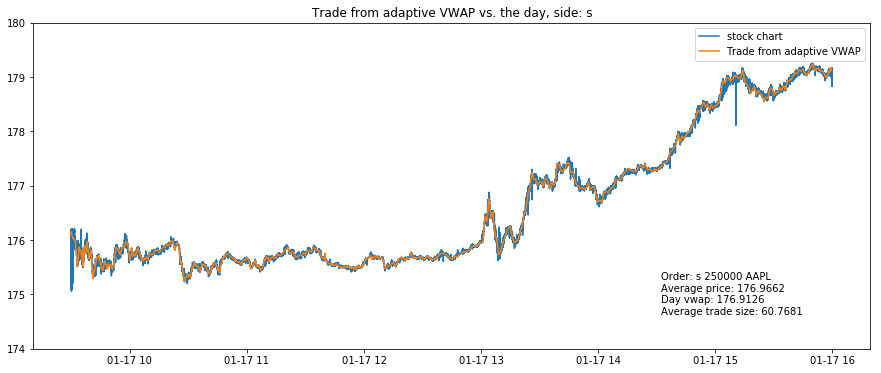

In [232]:
txt = 'Order: ' + order_side + ' ' + format( order_quantity, '.0f' ) + ' ' + ticker + '\n'
txt += 'Average price: ' + format( avg_price, '.4f' ) + '\n'
txt += 'Day vwap: ' + format( vwap, '.4f' ) + '\n'
txt += 'Average trade size: ' + format( trades[ 'shares' ].mean(), '.4f' ) + '\n'
# plot the results
f = plt.figure()
ax = f.add_subplot(111)
day_plot = plt.plot( all_trades[ 'Trade Price' ], label = 'stock chart' )
trade_plot = plt.plot( my_trades[ 'price' ], label = 'Trade from adaptive VWAP' )
plt.title( 'Trade from adaptive VWAP vs. the day, side: ' + order_side )
plt.ylim( 174, 180 )
plt.legend()
plt.text( 0.75, 0.15, txt,
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
plt.show()

## Visualization

In [233]:
market_trades = all_trades.copy()
market_trades.rename(columns = {'Trade Volume':'shares', 'Trade Price':'price', 'Time':'time'}, inplace = True)
market_trades['open'] = market_trades['price']
market_trades['close'] = market_trades['price']
market_trades['high'] = market_trades['price']
market_trades['low'] = market_trades['price']
market_trades = market_trades.groupby(['bar']).agg({'price': 'mean', 'open': 'first', 'close': 'last', \
                                    'high': 'max', 'low': 'min', 'shares': 'sum', 'time': 'last', })
market_trades['time'] = market_trades['time'].values.astype('datetime64[s]')
market_trades.head()

,price,open,close,high,low,shares,time
bar,,,,,,,
0,175.630123,176.150,176.0367,176.20,175.06,1156119.0,2018-01-17 09:30:59
1,176.062360,176.030,175.9600,176.21,175.96,246710.0,2018-01-17 09:31:59
2,175.798521,175.990,175.5300,176.00,175.52,189267.0,2018-01-17 09:32:59
3,175.712455,175.555,175.8200,175.99,175.51,183640.0,2018-01-17 09:33:59
4,175.764166,175.840,175.7700,175.89,175.65,101937.0,2018-01-17 09:34:59


In [234]:
mbt_trades = my_trades.copy()

In [235]:
# Bubble chart for trades
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(mbt_trades))]
data = [
    {
        'x': mbt_trades['time'],
        'y': mbt_trades['price'],
        'text': mbt_trades['shares'],
        'mode': 'markers',
        'marker': {
            'color': c,
            'size': mbt_trades['shares'] / 50,
        }
    }
]

py.iplot(data, filename='scatter-colorscale')

In [236]:
mbt_trades = my_trades.copy()
mbt_trades = mbt_trades.groupby(['bar']).agg({'price': 'mean','shares': 'sum', 'time': 'last', })
mbt_trades['time'] = mbt_trades['time'].values.astype('datetime64[s]')
mbt_trades['time'] = pd.to_datetime(mbt_trades['time'])
mbt_trades.head()

,price,shares,time
bar,,,
0,176.112609,1640.0,2018-01-17 09:30:00
1,176.028400,2764.0,2018-01-17 09:31:00
2,175.990000,146.0,2018-01-17 09:32:00
3,175.526765,2344.0,2018-01-17 09:33:00
4,175.842452,2791.0,2018-01-17 09:34:04


In [237]:
# Scatter plot to compare our Trade & Market
fig = {
    'data': [
        {'x': mbt_trades['time'], 'y': mbt_trades['price'], 'text': mbt_trades['shares'], 'mode': 'markers', 'name': 'trade'},
        {'x': market_trades['time'], 'y': market_trades['price'], 'text': market_trades['shares'], 'mode': 'markers', 'name': 'market'}
    ],
    'layout': {
        'xaxis': {'title': 'Time'},
        'yaxis': {'title': "Price"}
    }
}
py.iplot(fig)

In [240]:
# Generate box chart for each min

market_trades_2 = market_trades.iloc[100:230].copy()
mbt_trades_2 = mbt_trades.iloc[100:230].copy()

traces = []
for index, row in market_trades_2.iterrows():
    trades = []
    trades.append(row['high'])
    trades.append(row['low'])
    trades.append(row['open'])
    trades.append(row['close'])
    trades.append(row['price'])
#     y_data.append(trades)
    
    trace = go.Box(
        y = trades,
        name = row['time'],
        marker = dict(
            color = 'rgb(' + str(np.random.randint(255)) + ', ' + str(np.random.randint(255)) + ', ' + str(np.random.randint(255)) + ')',
        )
    )
    traces.append(trace)
    
    
trace1 = go.Scatter(
    x = mbt_trades_2['time'],
    y = mbt_trades_2['price']
)
traces.append(trace1)

data = traces
py.iplot(data)

In [204]:
# Plot signals and trade price

pos = [s/10.0 if s > 0 else 0 for s in signals]
neg = [-s/10.0 if s < 0 else 0 for s in signals]
len(market_trades)

data = [
    go.Scatter(
        x=market_trades['time'],
        y=market_trades['price'],
        error_y=dict(
            type='data',
            symmetric=False,
            array=pos,
            arrayminus=neg
        )
    )
]
py.iplot(data, filename='error-bar-asymmetric-array')